The goal here is to understand the properties of behavioural data and to compare the participants' responses to the responses of simulated agents with planning depth fixed at various levels.

In [1]:
%matplotlib inline
import numpy as np
from scipy import io

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='poster', style='white')
sns.set_palette("colorblind", n_colors=5, color_codes=True)

from os import listdir
import pandas as pd

import sys
sys.path.append('../')

In [36]:
from os.path import expanduser

def load_and_format_data(relative_path, cutoff=0):
    home = expanduser("~")

    path = home + relative_path  # change to correct path
    fnames = listdir(path)

    # define order and trial parameters
    T = 100
    n_subs = len(fnames)
    order = np.tile(range(1,5), (25,1)).flatten(order = 'F')
    mini_blocks = np.arange(1, T + 1)

    # inititate data frame
    data = pd.DataFrame(columns = ['gain', 
                                   'start_points', 
                                   'log_rt_1', 
                                   'log_rt_sum', 
                                   'subject', 
                                   'block_number', 
                                   'phase', 
                                   'order',
                                   'block_index',
                                   'end_points'])

    states = []
    responses = []
    
    subject = 0
    valid = np.ones(len(fnames)).astype(bool)
    for i,f in enumerate(fnames):
        parts = f.split('_')
        tmp = io.loadmat(path+f)
        points = tmp['data']['Points'][0, 0]

        # get response times
        rts = np.nan_to_num(tmp['data']['Responses'][0,0]['RT'][0,0])

        # get number of trials in each mini-block
        notrials = tmp['data']['Conditions'][0,0]['notrials'][0,0].flatten()

        # get points at the last trial of the miniblock
        end_points = points[range(100), (np.nan_to_num(notrials)-1).astype(int)]
        
        if end_points[-1] > cutoff:
            subject += 1
            states.append(tmp['data']['States'][0,0] - 1)
            responses.append(tmp['data']['Responses'][0,0]['Keys'][0,0] - 1)

            start_points = 1000
            df = pd.DataFrame()

            df['gain']= np.diff(np.hstack([start_points, end_points]))

            df['start_points'] = np.hstack([start_points, end_points])[:-1]
            df['end_points'] = end_points

            # define log_rt as the natural logarithm of the sum of response times over all trials
            df['log_rt_1']= np.log(rts[:, 0])
            df['log_rt_sum'] = np.log(np.nansum(rts, -1))

            df['subject'] = subject
            df['ID'] = parts[1]
            df['block_number'] = mini_blocks

            if notrials[0] == 3:
                df['phase'] = np.hstack([order[50:], order[:50]])
                df['order'] = 2
                df['block_index'] = np.hstack([mini_blocks[50:], mini_blocks[:50]])

            else:
                df['phase'] = order
                df['order'] = 1
                df['block_index'] = mini_blocks

            data = data.append(df, ignore_index=True, sort=False)
        else:
            valid[i] = False
    
    print('fraction of excluded participants ', 1. - subject/len(fnames))
    return data, states, responses, valid

In [43]:
### load behavioural data ###
from os.path import expanduser
home = expanduser("~")

path1 = '/tudcloud/Shared/Experiments/Plandepth/B03_pilot/main/OA/'  # change to correct path
path2 = '/tudcloud/Shared/Experiments/Plandepth/B03_pilot/main/YA/'

data_old, states_old, responses_old, valid_old = load_and_format_data(path1, cutoff=0)
data_young, states_young, responses_young, valid_young = load_and_format_data(path2, cutoff=0)

data_old['group'] = 'OA'
data_young['group'] = 'YA'

data = data_old.append(data_young, ignore_index=True)

fraction of excluded participants  0.0
fraction of excluded participants  0.0


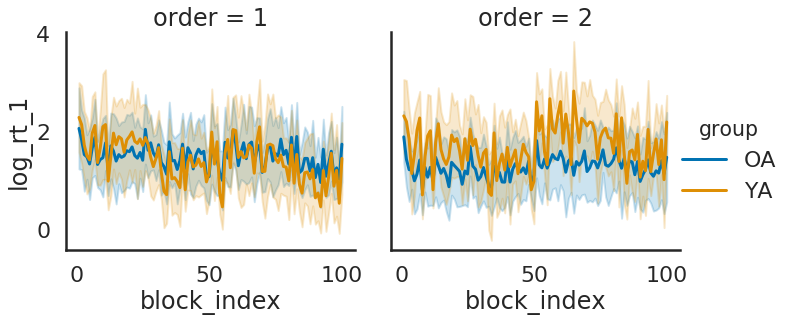

In [4]:
# plot mean of the log(rt_1) with 95% confidence interval or standard deviation
g = sns.FacetGrid(data, col="order", hue='group', height=5)
g = (g.map(sns.lineplot, "block_index", "log_rt_1", ci="sd").add_legend());

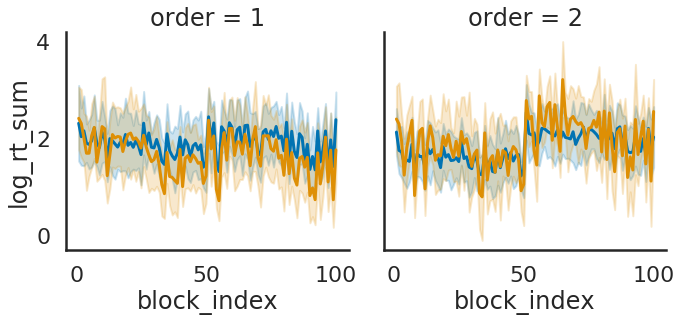

In [5]:
# plot mean of the log(sum rt) 
g = sns.FacetGrid(data, col="order", hue='group', height=5)
g.map(sns.lineplot, "block_index", "log_rt_sum", ci="sd");

In the plots above order = 1 denotes the experimental sequence in which participants start with 2 trial mini-blocks, and after 50 mini-blocks switch to 3 trial mini-blocks. Order = 2 denotes the reversered order in which participants start with 3 trial mini-blocks. The block index denotes the phase dependent index of a mini-block, where in order 1 condition we are counting blocks from 1 to 100, and in order 2 condition from 
50 to 100, and from 1 to 50. Hence, the above plots are aligned with respect to their condition.

To determine quantities which most influence response times we will perform a linear regression with respect to following predictor variables:
- logarithm of mini-block number 
- phase of the experiment 
- number of points at the beggining of the mini-block
- number of failures (surprising jumps) in the mini-block

In [6]:
def get_failures(states, responses):
    transitions = np.array([4., 3., 4., 5., 1., 1.])
    n_subs, n_blocks = states.shape[:2]
    
    failures = np.zeros((n_subs, n_blocks))    
    for i in range(n_subs):
        for j in range(2):
            nans = np.isnan(states[i,:,j+1])
            sts = states[i,~nans,j].astype(int)
            matching_trans = transitions[sts] == states[i,~nans, j+1]
            resp = responses[i,~nans,j].astype(bool)
            failures[i,~nans] += np.logical_xor(matching_trans, resp)
        nans = np.isnan(states[i,:,-1])
        failures[i] -= nans
    
    failures[failures < 0] = 0
    return failures

In [38]:
from bayesian_linear_regression import BayesLinRegress

T = 100

def sample_posterior(data, states, responses):
    n_subs = len(np.unique(data.subject))
    y1 = data['log_rt_1'].values.reshape(n_subs, T).T
    y2 = data['log_rt_sum'].values.reshape(n_subs, T).T
    X = np.log(np.expand_dims(data['block_number'].values.astype(int).reshape(n_subs, T).T, -1))
    
    # center all non-constant factors per phase
    X -= X.mean(0)
    
    # these are constant per phase
    phases = data.phase.values.astype(int).reshape(n_subs, T).T - 1
    X = np.concatenate([X, np.eye(4)[phases]], -1)

    start_points = data.start_points.values.copy().reshape(n_subs, T).T
    start_points -= start_points.mean(0)
    X = np.concatenate([X, np.expand_dims(start_points, -1)], -1)
    
    m1 = BayesLinRegress(np.swapaxes(X, 0, 1), y1.T)

    states = np.array(states)
    responses = np.array(responses)
    failures = get_failures(states, responses).T
    failures -= failures.mean(0)
    
    X = np.concatenate([X, np.expand_dims(failures, -1)], -1)

    m2 = BayesLinRegress(np.swapaxes(X, 0, 1), y2.T)

    samples = []
    for m in [m1, m2]:
        samples.append(m.fit(num_samples=1000, warmup_steps=5000, summary=False))
        print('model ppll', m.post_pred_log_likelihood())
        
    return samples

In [39]:
samples_old = sample_posterior(data_old, states_old, responses_old)

sample: 100%|██████████| 6000/6000 [02:54<00:00, 34.45it/s, 511 steps of size 7.67e-03. acc. prob=0.86]  


model ppll -1483.2063


sample: 100%|██████████| 6000/6000 [04:05<00:00, 24.41it/s, 1023 steps of size 6.27e-03. acc. prob=0.85] 


model ppll -1145.1143


In [44]:
samples_young = sample_posterior(data_young, states_young, responses_young)

sample: 100%|██████████| 6000/6000 [02:06<00:00, 47.39it/s, 255 steps of size 1.42e-02. acc. prob=0.78] 


model ppll -2270.9004


sample: 100%|██████████| 6000/6000 [03:14<00:00, 30.91it/s, 1023 steps of size 5.17e-03. acc. prob=0.90]


model ppll -2078.404


In [45]:
### visualise regression results ###

import numpy as onp

betas = {'old': [], 'young': []}
for smpl1, smpl2 in zip(samples_old, samples_young):
    betas['old'].append(onp.array(smpl1['beta']).astype(onp.double))
    betas['young'].append(onp.array(smpl2['beta']).astype(onp.double))

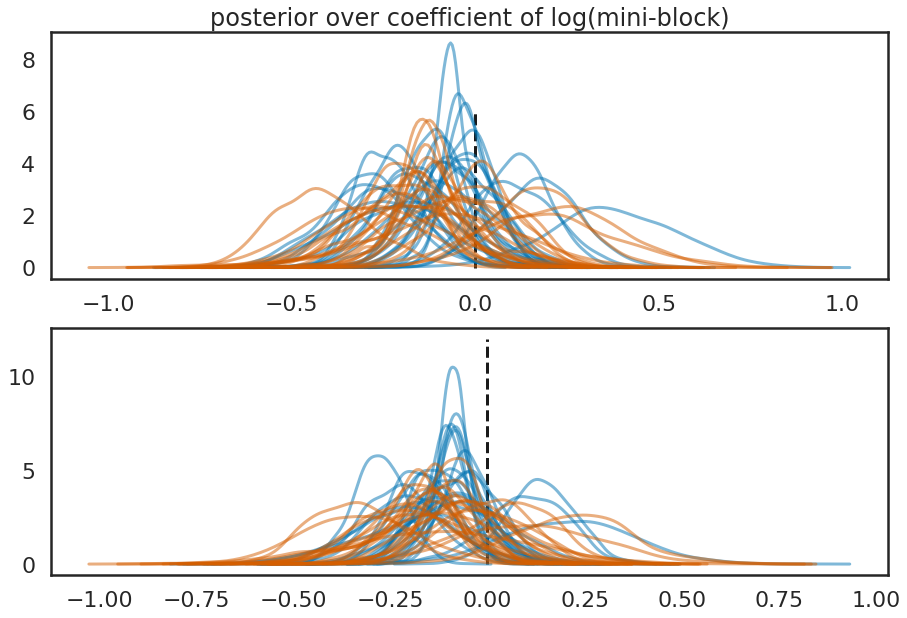

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

color = {'old': 'b', 'young': 'r'}

for group in betas:
    n_sub = betas[group][0].shape[-2]
    for i in range(n_sub):
        sns.kdeplot(betas[group][0][:, i, 0], color=color[group], alpha=.5, label=i+1, ax=ax[0], legend=False)
        sns.kdeplot(betas[group][1][:, i, 0], color=color[group], alpha=.5, label=i+1, ax=ax[1], legend=False)

# ax[0].legend(title='subject');
ax[0].vlines(0, 0, 6, 'k', linestyle='--');
ax[1].vlines(0, 0, 12, 'k', linestyle='--');
ax[0].set_title('posterior over coefficient of log(mini-block)');

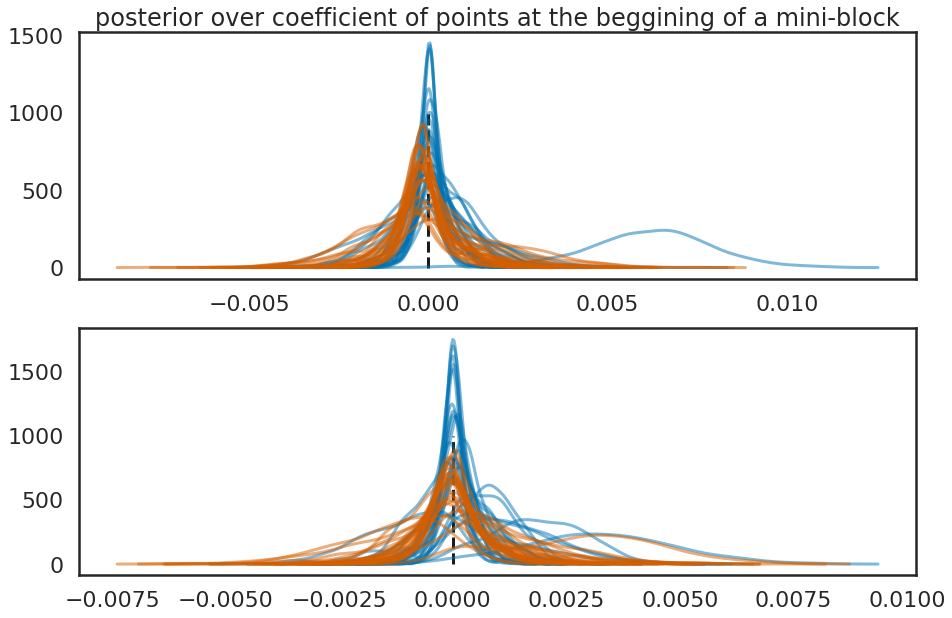

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
color = {'old': 'b', 'young': 'r'}

for group in betas:
    n_sub = betas[group][0].shape[-2]
    for i in range(n_sub):
        sns.kdeplot(betas[group][0][:, i, -1], color=color[group], alpha=.5, label=i+1, ax=ax[0], legend=False)
        sns.kdeplot(betas[group][1][:, i, -2], color=color[group], alpha=.5, label=i+1, ax=ax[1], legend=False)

# ax[0].legend(title='subject');
ax[0].vlines(0, 0, 1000, 'k', linestyle='--');
ax[1].vlines(0, 0, 1000, 'k', linestyle='--');
ax[0].set_title('posterior over coefficient of points at the beggining of a mini-block');

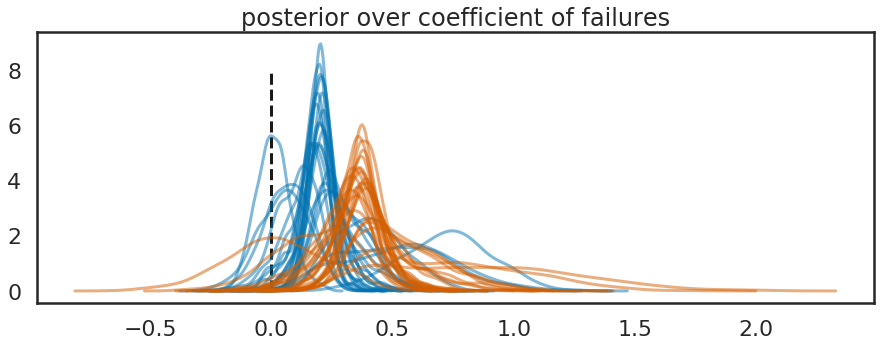

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
color = {'old': 'b', 'young': 'r'}

for group in betas:
    n_sub = betas[group][1].shape[-2]
    for i in range(n_sub):
        sns.kdeplot(betas[group][1][:, i, -1], color=color[group], alpha=.5, label=i+1, ax=ax, legend=False)


# plt.legend(title='subject');
plt.vlines(0, 0, 8, 'k', linestyle='--');
plt.title('posterior over coefficient of failures');

In [49]:
# plot phase coefficients
def compare_phase_coefficients(mu_w, sigma_w):
    fig, ax = plt.subplots(2, 2, figsize = (10, 5), sharey = True, sharex = True)

    ax[0,0].errorbar(mu_w[:, 0], mu_w[:, 1], 
                     xerr=sigma_w[:, 0], 
                     yerr=sigma_w[:, 1], 
                     fmt='o',
                     elinewidth = 1,
                     alpha = .8);
    ax[0,1].errorbar(mu_w[:, 2], mu_w[:, 1], 
                     xerr=sigma_w[:, 2], 
                     yerr=sigma_w[:, 1], 
                     fmt='o',
                     elinewidth = 1,
                     alpha = .8);

    ax[1,0].errorbar(mu_w[:, 0], mu_w[:, 3], 
                     xerr=sigma_w[:, 0], 
                     yerr=sigma_w[:, 3], 
                     fmt='o',
                     elinewidth = 1,
                     alpha = .8);

    ax[1,1].errorbar(mu_w[:, 2], mu_w[:, 3], 
                     xerr=sigma_w[:, 2],
                     yerr=sigma_w[:, 3],
                     fmt='o',
                     elinewidth = 1,
                     alpha = .8);

    ax[0,0].set_ylabel(r'$\ln(rt(I))$')
    ax[1,0].set_xlabel(r'$\ln(rt(II))$')
    ax[1,0].set_ylabel(r'$\ln(rt(IV))$')
    ax[1,1].set_xlabel(r'$\ln(rt(III))$')

    x = np.arange(mu_w.min(), mu_w.max(), .1)
    ax[0,0].plot(x, x, 'k--', lw = 2)
    ax[0,1].plot(x, x, 'k--', lw = 2)
    ax[1,0].plot(x, x, 'k--', lw = 2)
    ax[1,1].plot(x, x, 'k--', lw = 2)

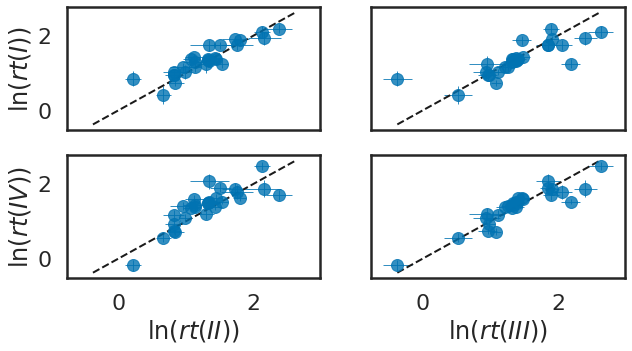

In [50]:
mu_w = betas['old'][0][..., 1:5].mean(0)
sigma_w = betas['old'][0][..., 1:5].std(0)

compare_phase_coefficients(mu_w, sigma_w)

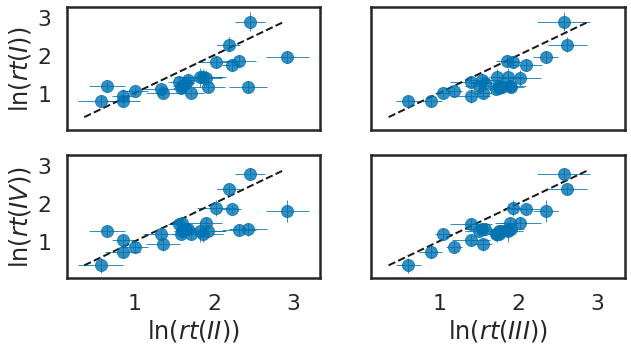

In [51]:
mu_w = betas['young'][0][..., 1:5].mean(0)
sigma_w = betas['young'][0][..., 1:5].std(0)

compare_phase_coefficients(mu_w, sigma_w)

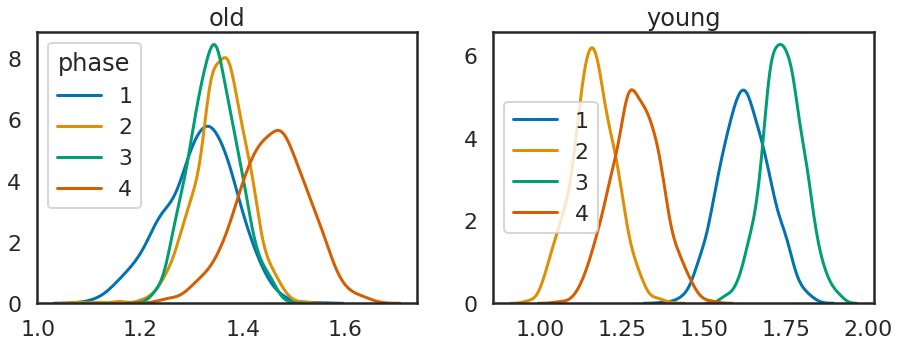

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

smpl_old = onp.array(samples_old[0]['group_beta'])
smpl_young = onp.array(samples_young[0]['group_beta'])

for i, smpl in enumerate([smpl_old, smpl_young]):
    for j in range(1, smpl.shape[-1] - 1):
        sns.kdeplot(smpl[..., j].flatten(), label=j, ax=axes[i])
    
axes[0].legend(title='phase');
axes[0].set_title('old');
axes[1].set_title('young');

Overal we see more structure in the estimates of the regression coefficients when using log of the sum of response times instead of the first response time, as a response variable.

## Simulated behaviour
In what follows we will compare subjects preformance with the performance of simulated agents

In [53]:
import torch

from tasks import SpaceAdventure
from agents import BackInduction
from simulate import Simulator

exp = io.loadmat('../experiment/experimental_variables_new.mat')
starts = exp['startsExp'][:, 0] - 1
planets = exp['planetsExp'] - 1
vect = np.eye(5)[planets]

# setup parameters for the task environment
runs = 50
blocks = 100
na = 2
ns = 6
no = 5

ol1 = torch.from_numpy(vect)
ol2 = torch.from_numpy(np.vstack([vect[50:], vect[:50]]))

starts1 = torch.from_numpy(starts)
starts2 = torch.from_numpy(np.hstack([starts[50:], starts[:50]]))
    
noise = np.tile(np.array([0, 1, 0, 1]), (25,1)).T.flatten()
trials1 = np.tile(np.array([2, 2, 3, 3]), (25,1)).T.flatten()
trials2 = np.tile(np.array([3, 3, 2, 2]), (25,1)).T.flatten()

costs = torch.FloatTensor([-2, -5])  # action costs
fuel = torch.arange(-20., 30., 10.)  # fuel reward of each planet type

confs = torch.stack([ol1, ol2])
confs = confs.view(2, 1, blocks, ns, no).repeat(1, runs//2, 1, 1, 1)\
        .reshape(-1, blocks, ns, no).float()

starts = torch.stack([starts1, starts2])
starts = starts.view(2, 1, blocks).repeat(1, runs//2, 1)\
        .reshape(-1, blocks)
        
conditions = torch.zeros(2, runs, blocks, dtype=torch.long)
conditions[0] = torch.tensor(noise, dtype=torch.long)[None,:]
conditions[1, :runs//2] = torch.tensor(trials1, dtype=torch.long)
conditions[1, runs//2:] = torch.tensor(trials2, dtype=torch.long)

In [54]:
# iterate over different planning depths
agents = []
simulations = []
performance = []
for depth in range(3):
    
    # define space adventure task with aquired configurations
    # set number of trials to the max number of actions
    space_advent = SpaceAdventure(conditions,
                                  outcome_likelihoods=confs,
                                  init_states=starts,
                                  runs=runs,
                                  mini_blocks=blocks,
                                  trials=3)
    
    # define the optimal agent, each with a different maximal planning depth
    agent = BackInduction(confs,
                          runs=runs,
                          mini_blocks=blocks,
                          trials=3,
                          planning_depth=depth+1)
    
    agent.set_parameters()
    
    # simulate experiment
    sim = Simulator(space_advent, 
                    agent, 
                    runs=runs, 
                    mini_blocks=blocks,
                    trials=3)
    sim.simulate_experiment()
    
    simulations.append(sim)
    agents.append(agent)
    
    responses = sim.responses.clone()
    responses[torch.isnan(responses)] = 0
    responses = responses.long()
    
    outcomes = sim.outcomes
    
    points = costs[responses] + fuel[outcomes]
    points[outcomes<0] = 0
    performance.append(points.sum(-1))

In [55]:
sim_data = pd.DataFrame()
rel_score = np.zeros((3, 4))
for depth in range(3):
    start_points = 1000
    end_points = start_points + performance[depth].numpy().cumsum(-1)
    points = np.hstack([start_points*np.ones((runs, 1)), end_points])
    df = pd.DataFrame(points.T, columns=range(runs))
    df['mini-block'] = np.arange(blocks + 1)
    df = pd.melt(df, id_vars='mini-block', value_vars=range(runs), value_name='points')
    df['order'] = 1
    df.loc[df.variable >= runs//2, 'order'] = 2
    df['depth'] = depth + 1
    sim_data = sim_data.append(df, ignore_index=True)
    
    phase_values = np.concatenate([start_points*np.ones((runs, 1)), end_points.reshape(-1, 4, 25)[..., -1]], -1)
    diffs = np.diff(phase_values, axis=-1)
                    
    diffs[runs//2:, :] = np.concatenate([diffs[runs//2:, 2:], diffs[runs//2:, :2]], -1) 
    
    rel_score[depth] = diffs.mean(0)/25

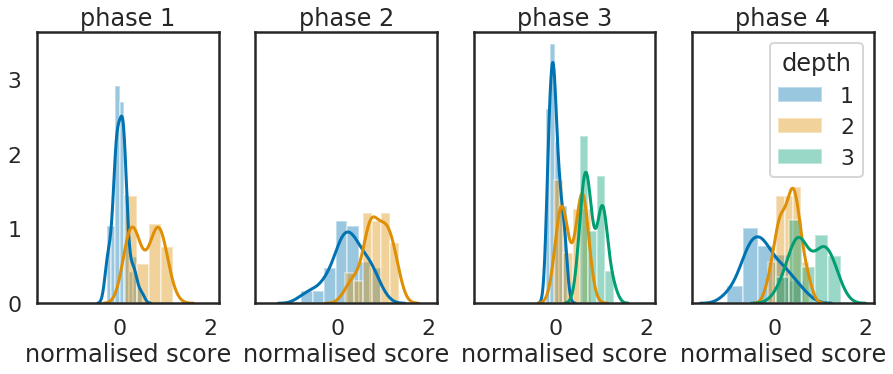

In [56]:
import seaborn as sns
norm_score = np.zeros((3, runs, 4))
for depth in range(3):
    df = sim_data.loc[sim_data.depth == depth+1]
    end_points = df['points'].values.reshape(runs, -1)[:, 1:]
    
    end_phase_points = np.concatenate([start_points*np.ones((runs, 1)), end_points.reshape(-1, 4, 25)[..., -1]], -1)
    phase_diffs = np.diff(end_phase_points, axis=-1)
    
    phase_diffs[runs:, :] = np.concatenate([phase_diffs[runs:, 2:], phase_diffs[runs:, :2]], -1) 
    
    norm_score[depth] = (phase_diffs/25 - rel_score[0])/(rel_score[-1] - rel_score[0])

fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharex=True, sharey=True)

for i in range(4):
    axes[i].set_title('phase {}'.format(i + 1))
    axes[i].set_xlabel('normalised score')
    for d in range(3):
        if i < 2:
            if d < 2:
                sns.distplot(norm_score[d, :, i].T, ax=axes[i])
        else:
            sns.distplot(norm_score[d, :, i].T, ax=axes[i])
        
axes[-1].legend([1, 2, 3], title='depth')
fig.savefig('simulates_normalised_scores.pdf', dpi=300)

In [57]:
from scipy.stats import mannwhitneyu, wilcoxon

print(mannwhitneyu(norm_score[-1, :, 0], norm_score[-1, :, 1]))
print(mannwhitneyu(norm_score[-1, :, 0], norm_score[-2, :, 1]))

print(mannwhitneyu(norm_score[-1, :, 2], norm_score[-1, :, 3]))
print(mannwhitneyu(norm_score[-1, :, 2], norm_score[-2, :, 3]))
print(mannwhitneyu(norm_score[-1, :, 2], norm_score[-3, :, 3]))

print(mannwhitneyu(norm_score[-1, :, 0], norm_score[-1, :, 2]))
print(mannwhitneyu(norm_score[-2, :, 1], norm_score[-2, :, 3]))
print(mannwhitneyu(norm_score[-2, :, 1], norm_score[-3, :, 3]))

MannwhitneyuResult(statistic=1189.0, pvalue=0.3383072531389616)
MannwhitneyuResult(statistic=456.0, pvalue=2.243520718248041e-08)
MannwhitneyuResult(statistic=1120.0, pvalue=0.18598127306315665)
MannwhitneyuResult(statistic=117.0, pvalue=2.9121405692408104e-15)
MannwhitneyuResult(statistic=32.0, pvalue=2.3547972645822667e-17)
MannwhitneyuResult(statistic=308.0, pvalue=4.266214322611726e-11)
MannwhitneyuResult(statistic=207.0, pvalue=3.307309202461376e-13)
MannwhitneyuResult(statistic=48.0, pvalue=5.986786009183055e-17)


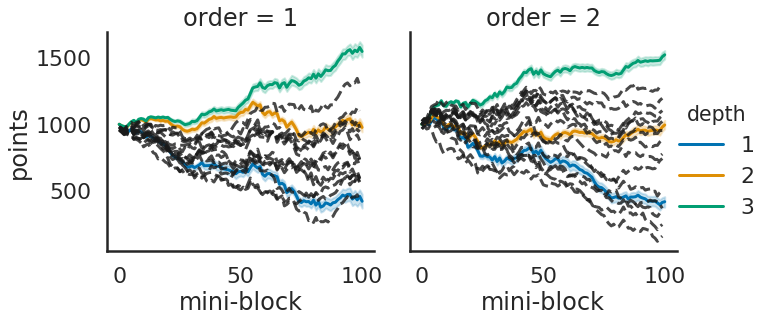

In [58]:
g = sns.FacetGrid(sim_data, col="order", hue='depth', height=5)
g.map(sns.lineplot, "mini-block", "points").add_legend();
mini_blocks = np.arange(1, 101)

for order in range(2):
    for subject in np.unique(data_old.subject.values):
        df = data_old.loc[data_old.order == order+1]
        points = df.loc[df.subject == subject]['end_points'].values
        if len(points) == blocks:
            g.axes[0, order].plot(mini_blocks - 1, points, 'k--', alpha=.8)

In the above plot we are comparing point counts of individual subjects (dashed black lines) with the mean performance of agents with fixed planning depth. Visual inspection sudjest that in the first group of participants (order = 1) one of the participants eventually behaved as agent of planning depth 3, while the other two are mostly behaving as planning depth 1 agents. In the second group (order = 2) we have one participant which was performing in the range between planning depth 2 and 3 agents and another with low planning depth of 1. Overal, this results suggest that old adults are able to performe the task to certain degree but that we should expect large variability in performance (I would expect in the control group performance variability to be much smaller).

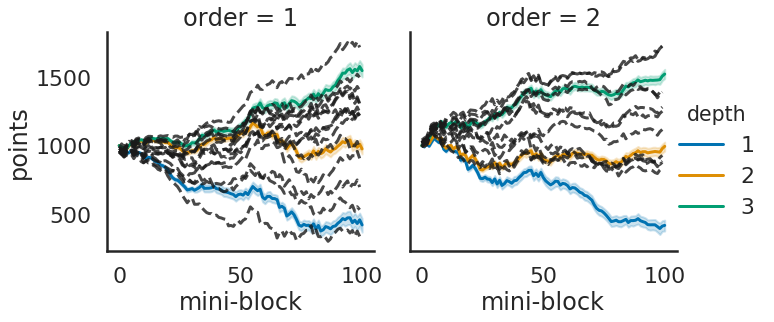

In [59]:
g = sns.FacetGrid(sim_data, col="order", hue='depth', height=5)
g.map(sns.lineplot, "mini-block", "points").add_legend();
mini_blocks = np.arange(1, 101)

for order in range(2):
    for subject in np.unique(data_young.subject.values):
        df = data_young.loc[data_young.order == order+1]
        points = df.loc[df.subject == subject]['end_points'].values
        if len(points) == blocks:
            g.axes[0, order].plot(mini_blocks - 1, points, 'k--', alpha=.8)

Compared to old adults, in the young adults data set we find larger percentage of participants that used the maximal planning depth throughout the experiment.

MannwhitneyuResult(statistic=347.0, pvalue=0.3843408978339796)
MannwhitneyuResult(statistic=256.0, pvalue=0.03085086516672777)
MannwhitneyuResult(statistic=273.0, pvalue=0.05770930158195463)
MannwhitneyuResult(statistic=334.0, pvalue=0.30187716710938706)


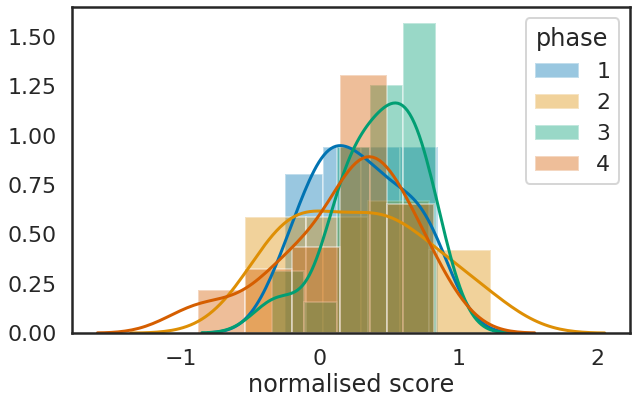

In [95]:
# load planning depth statistics for OA group
pd_stats_oa = np.load('oa_plandepth_stats_B03.npz', allow_pickle=True)
pd_prob_oa = pd_stats_oa['arr_1'][0]  # planning depth probability for the first choice

ep_count_oa = pd_stats_oa['arr_2'][0]  # exc. prob. count for the first choice
ep_prob_oa = ep_count_oa/ep_count_oa.sum(0)
ep_oa = ep_prob_oa.reshape(3, 4, 25, -1).mean(-2)
#######################################################################3

n_subs = pd_prob_oa.shape[1]

score = data_old['gain'].values.reshape(n_subs, 4, -1).sum(-1)/25
order = data_old.order.values.reshape(n_subs, -1)[:, 0]
rev = order == 2

mpd_all_oa = pd_prob_oa.dot(np.arange(1, 4)).reshape(4, 25, -1)
mpd_oa = mpd_all_oa.mean(-2).T
vpd_oa = mpd_all_oa.std(-2).T

mpd_all_oa[..., rev] = np.concatenate([mpd_all_oa[2:, :, rev], mpd_all_oa[:2, :, rev]], 0)
mpd_oa[rev] = np.concatenate([mpd_oa[rev, 2:], mpd_oa[rev, :2]], -1)
vpd_oa[rev] = np.concatenate([vpd_oa[rev, 2:], vpd_oa[rev, :2]], -1)
ep_oa[..., rev] = np.concatenate([ep_oa[:, 2:, rev], ep_oa[:, :2, rev]], -2)

# create data frame with ep and entorpy estimates
data_oa = pd.DataFrame(data=ep_oa[[-2, -2, -1, -1], [0, 1, 2, 3]].T, columns=[1, 2, 3, 4])
data_oa['order'] = order
data_oa = data_oa.melt(id_vars='order', var_name='phase', value_name='EP(depth=max)')
data_oa['group'] = 'OA'

df = pd.DataFrame(data=vpd_oa, columns=[1, 2, 3, 4])
data_oa['std'] = df.melt(var_name='phase', value_name='entropy')['entropy']

score[rev] = np.concatenate([score[rev, 2:], score[rev, :2]], -1)
norm_score1 = (score - rel_score[0])/(rel_score[-1] - rel_score[0])

fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)

axes.set_xlabel('normalised score')
for i in range(4):
    sns.distplot(norm_score1[:, i], ax=axes)
    
axes.legend([1, 2, 3, 4], title='phase')

from scipy.stats import mannwhitneyu, wilcoxon

print(mannwhitneyu(norm_score1[:, 0], norm_score1[:, 1]))
print(mannwhitneyu(norm_score1[:, 2], norm_score1[:, 3]))
print(mannwhitneyu(norm_score1[:, 0], norm_score1[:, 2]))
print(mannwhitneyu(norm_score1[:, 1], norm_score1[:, 3]))

MannwhitneyuResult(statistic=276.0, pvalue=0.24242622380595702)
MannwhitneyuResult(statistic=190.0, pvalue=0.008960135952804888)
MannwhitneyuResult(statistic=312.0, pvalue=0.5)
MannwhitneyuResult(statistic=219.0, pvalue=0.03557243058678308)


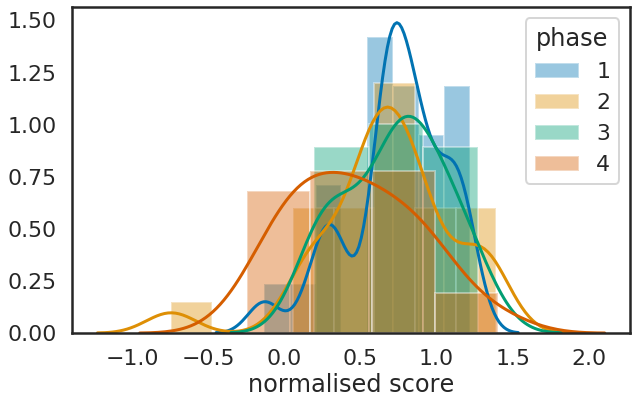

In [96]:
# load planning depth statistics for YA group
pd_stats_ya = np.load('ya_plandepth_stats_B03.npz', allow_pickle=True)
pd_prob_ya = pd_stats_ya['arr_1'][0]  # planning depth probability for the first choice

ep_count_ya = pd_stats_ya['arr_2'][0]  # exc. prob. count for the first choice
ep_prob_ya = ep_count_ya/ep_count_ya.sum(0)
ep_ya = ep_prob_ya.reshape(3, 4, 25, -1).mean(-2)
####################################################################################

n_subs = pd_prob_ya.shape[1]

mpd_all_ya = pd_prob_ya.dot(np.arange(1, 4)).reshape(4, 25, -1)
mpd_ya = mpd_all_ya.mean(-2).T
vpd_ya = mpd_all_ya.std(-2).T

order = data_young.order.values.reshape(n_subs, -1)[:, 0]
rev = order == 2

mpd_all_ya[..., rev] = np.concatenate([mpd_all_ya[2:, :, rev], mpd_all_ya[:2, :, rev]], 0)
mpd_ya[rev] = np.concatenate([mpd_ya[rev, 2:], mpd_ya[rev, :2]], -1)
vpd_ya[rev] = np.concatenate([vpd_ya[rev, 2:], vpd_ya[rev, :2]], -1)
ep_ya[..., rev] = np.concatenate([ep_ya[:, 2:, rev], ep_ya[:, :2, rev]], -2)

data_ya = pd.DataFrame(data=ep_ya[[-2, -2, -1, -1], [0, 1, 2, 3]].T, columns=[1, 2, 3, 4])
data_ya['order'] = order
data_ya = data_ya.melt(id_vars='order', var_name='phase', value_name='EP(depth=max)')
data_ya['group'] = 'YA'

df = pd.DataFrame(data=vpd_ya, columns=[1, 2, 3, 4])
data_ya['std'] = df.melt(var_name='phase', value_name='entropy')['entropy']

score = data_young['gain'].values.reshape(n_subs, 4, -1).sum(-1)/25
score[rev] = np.concatenate([score[rev, 2:], score[rev, :2]], -1)
norm_score2 = (score - rel_score[0])/(rel_score[-1] - rel_score[0])

fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
axes.set_xlabel('normalised score')
for i in range(4):
    sns.distplot(norm_score2[:, i], ax=axes)
    
axes.legend([1, 2, 3, 4], title='phase')

from scipy.stats import mannwhitneyu, wilcoxon

print(mannwhitneyu(norm_score2[:, 0], norm_score2[:, 1]))
print(mannwhitneyu(norm_score2[:, 2], norm_score2[:, 3]))
print(mannwhitneyu(norm_score2[:, 0], norm_score2[:, 2]))
print(mannwhitneyu(norm_score2[:, 1], norm_score2[:, 3]))

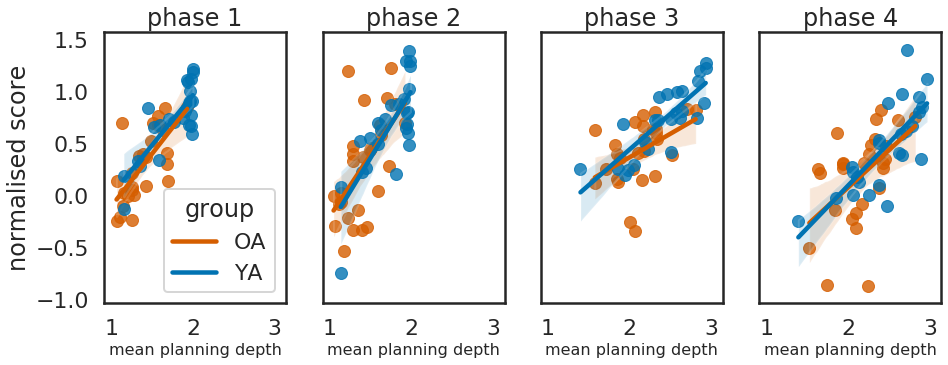

In [62]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True, sharex=True)

mpd = [mpd_oa, mpd_ya]
ns = [norm_score1, norm_score2]
color = ['r', 'b'] 
for j in range(2):
    for i in range(4):
        sns.regplot(mpd[j][:, i], ns[j][:, i], ax=axes[i], color=color[j])
        axes[i].set_title('phase {}'.format(i+1));
        axes[i].set_xlabel('mean planning depth', fontsize=16);
    
axes[0].set_ylabel('normalised score');
axes[0].legend(['OA', 'YA'], title='group')

fig.savefig('score_vs_depth_B03.pdf', dpi=300)    

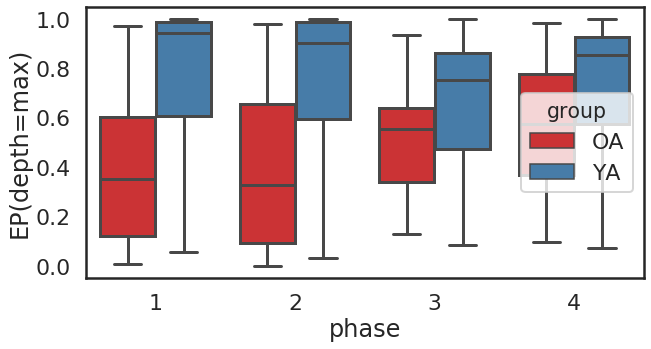

In [63]:
data = data_oa.append(data_ya, ignore_index=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.boxplot('phase', 'EP(depth=max)', data=data, hue='group', ax=ax, palette='Set1')

fig.savefig('ep_dist_B03.pdf', dpi=300)

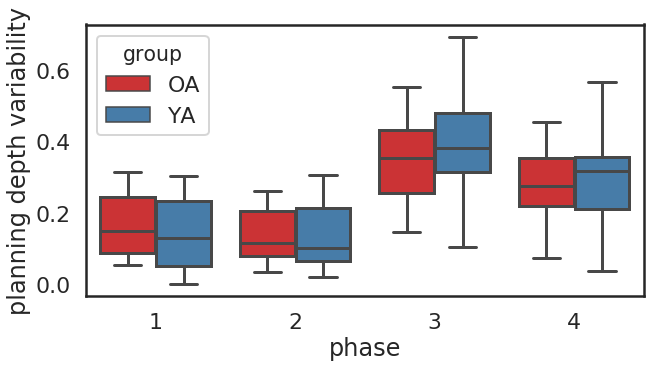

In [138]:
data = data_oa.append(data_ya, ignore_index=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.boxplot('phase', 'std', data=data, hue='group', ax=ax, palette='Set1')
ax.set_ylabel('planning depth variability')

fig.savefig('variability_dist_B03.pdf', dpi=300)

In [111]:
df1.melt(id_vars=['block_index'], var_name='subject')

,block_index,subject,value
0,1,0,1.812309
1,2,0,1.772652
2,3,0,1.224008
3,4,0,1.833719
4,5,0,1.294495
...,...,...,...
2695,96,26,2.276792
2696,97,26,2.211855
2697,98,26,2.273880
2698,99,26,2.187378


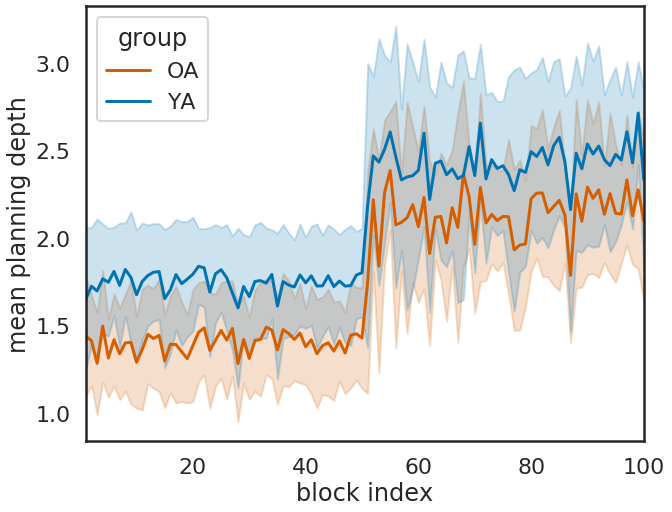

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

df1 = pd.DataFrame(mpd_all_oa.reshape(blocks, -1))
df1['block_index'] = np.arange(1, blocks+1)
df1 = df1.melt(id_vars=['block_index'], var_name='subject')

df2 = pd.DataFrame(mpd_all_ya.reshape(blocks, -1))
df2['block_index'] = np.arange(1, blocks+1)
df2 = df2.melt(id_vars=['block_index'], var_name='subject')

sns.lineplot(x='block_index', y='value', data=df1, color='r', ci='sd', label='OA');
sns.lineplot(x='block_index', y='value', data=df2, color='b', ci='sd', label='YA');

ax.set_ylabel('mean planning depth');
ax.set_xlabel('block index');
ax.legend(title='group', loc=2);
ax.set_xlim([1, 100]);

fig.savefig('build3_b03.png', dpi=600)
fig.savefig('build3_b03.svg', dpi=300)


In [113]:
n_sub_oa = mpd_oa.shape[0]
n_sub_ya = mpd_ya.shape[0]

ids = [data_old['ID'].values.reshape(n_sub_oa, -1)[:, 0],
       data_young['ID'].values.reshape(n_sub_ya, -1)[:, 0]]
gl = ['OA', 'YA']
mpd = [mpd_oa, mpd_ya]
ns = [norm_score1, norm_score2]
vpd = [vpd_oa, vpd_ya]
ep = [ep_oa[[-2, -2, -1, -1], [0, 1, 2, 3]], ep_ya[[-2, -2, -1, -1], [0, 1, 2, 3]]]

results = pd.DataFrame()
for g in range(2):
    for phase in range(4):
        df = pd.DataFrame({'PD': mpd[g][:, phase], 
                           'NS': ns[g][:, phase],
                           'STD': vpd[g][:, phase],
                           'EP(depth=max)': ep[g][phase],
                           'subject': np.arange(1, ns[g].shape[0] +1),
                           'ID': ids[g],
                           'phase': phase + 1,
                           'group': gl[g]})
        
        results = results.append(df, ignore_index=True)
        
results.to_csv('NS_PD_Entropy_B03.csv')

MannwhitneyuResult(statistic=2576.0, pvalue=3.752240703815699e-11)

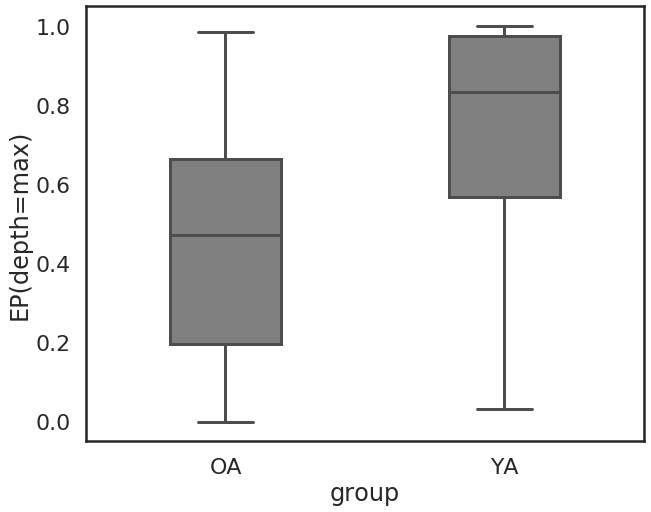

In [87]:
data = data_oa.append(data_ya, ignore_index=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.boxplot('group', 'EP(depth=max)', data=results, ax=ax, color='gray', width=0.4)

fig.savefig('bild2_B03.eps', dpi=300)
fig.savefig('bild2_B03.png', dpi=600)

mannwhitneyu(results.loc[results.group == 'OA', 'EP(depth=max)'], results.loc[results.group == 'YA', 'EP(depth=max)'])

MannwhitneyuResult(statistic=5315.0, pvalue=0.4227618798022342)

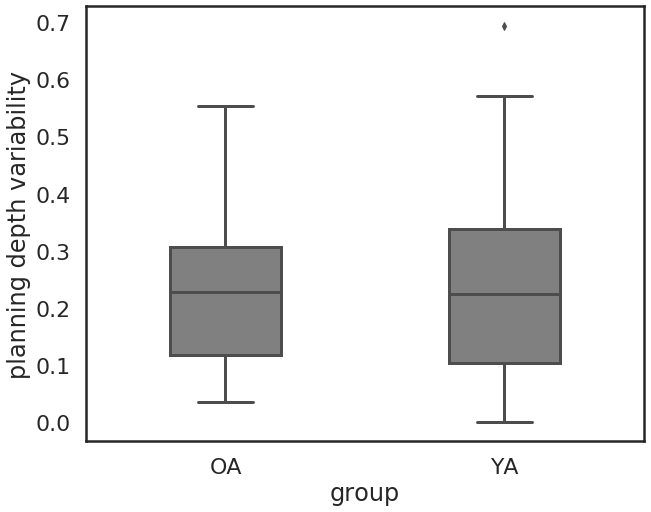

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.boxplot(x='group', y='STD', data=results, color='gray', width=0.4)

ax.set_ylabel('planning depth variability')

fig.savefig('planning_depth_variability_B03.eps', dpi=300)
fig.savefig('planning_depth_variability_B03.png', dpi=600)

mannwhitneyu(results.loc[results.group == 'OA', 'STD'], results.loc[results.group == 'YA', 'STD'])

MannwhitneyuResult(statistic=3430.0, pvalue=2.7980015114332186e-06)

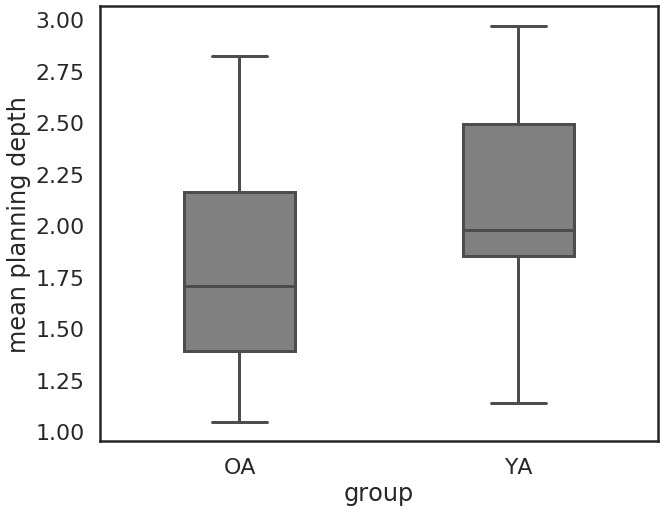

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.boxplot(x='group', y='PD', data=results, color='gray', width=0.4)

ax.set_ylabel('mean planning depth')


fig.savefig('bild1_B03.eps', dpi=300)
fig.savefig('bild1_B03.png', dpi=600)
mannwhitneyu(results.loc[results.group == 'OA', 'PD'], results.loc[results.group == 'YA', 'PD'])